# Starter Notebook
This notebook contains the main code to train a GeodesyNet on accelerations synthetically generated from a mascon model.
At the end of the training a quick look at the resulting neural density field is also given.

To run this notebook we recommend to create a conda environment using the following commands:
```
 conda create -n geodesynets python=3.8 ipython numpy scipy scikit-learn  h5py matplotlib jupyter tqdm pandas
 conda activate geodesynets
 conda install -c pytorch pytorch
 conda install -c open3d-admin open3d
 pip install sobol_seq
 pip install tetgen
 conda install pyvista pyvistaqt
```

To use CUDA, you will need to run
```
 conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
```

On CPU the training will still work but be slow, so use less points for the numercial quadrature and smaller batches. If you have access to a GPU everything will go much faster. With an Nvidia RTX2080Ti GPU a full training will take approximately one hour.

In [1]:
# Import our module containing helper functions
import gravann

# Core imports
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

Available devices  1
__pyTorch VERSION: 1.10.0
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


C:\ProgramData\Miniconda3\envs\geodesynet\lib\site-packages\pyvista\themes.py:123: PyvistaDeprecationWarning: use "dark" instead of "night" theme
  warnings.warn('use "dark" instead of "night" theme', PyvistaDeprecationWarning)


# Loading and visualizing the ground truth asteroid (a point cloud)

In [2]:
# We load the ground truth (a mascon model of some body)
with open("mascons/Bennu.pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses = torch.tensor(mascon_masses)

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

# Each mascon has a closest neighbour. The least close one is here computed (non dimensional units).
# Its a quantity that is of interest when checking mascon models coming from gravitationally stable aggregates.
print("Maximal minimal distance:",gravann.max_min_distance(mascon_points))

Name:  Bennu
Number of mascons:  37799
Total mass:  tensor(1.0000, dtype=torch.float64)
Maximal minimal distance: 0.13160134851932526


<IPython.core.display.Javascript object>


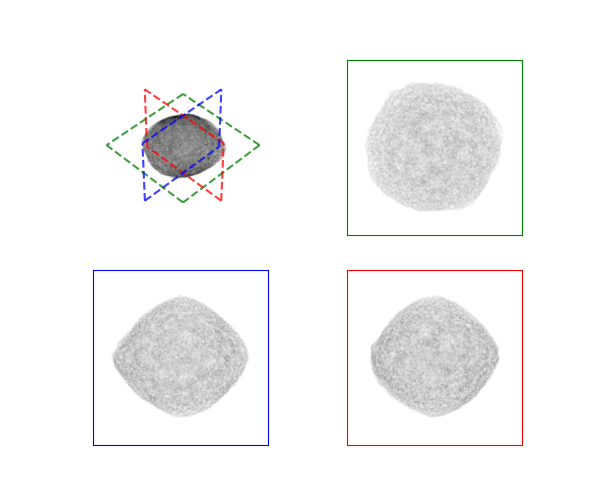

In [3]:
# Here we visualize the loaded ground truth
gravann.plot_mascon(mascon_points, mascon_masses)

# Representing the asteroid mass distribution via a neural network


## 1 - Defining the network architecture
We here use functions from our module as to not clutter the notebook, but the code is rather straight forward: a FFNN with some options.

In [4]:
# Encoding: direct encoding (i.e. feeding the network directly with the Cartesian coordinates in the unit hypercube)
# was found to work well in most cases. But more options are implemented in the module.
encoding = gravann.direct_encoding()

# The model is here a SIREN network (FFNN with sin non linearities and a final absolute value to predict the density)
model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.AbsLayer())
#model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.SquaredReLU())
#model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = torch.nn.ReLU())


# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
# .. and we init a loss trend indicators
weighted_average = deque([], maxlen=20)

In [5]:
## IF YOU WANT TO LOAD AN ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail

#model.load_state_dict(torch.load("models/planetesimal.mdl"))

# Once a model is loaded the learned constant c (named kappa in the paper) is unknown 
# and must be relearned (ideally it should also be saved at the end of the training as it is a learned parameter)
c = gravann.compute_c_for_model(model, encoding, mascon_points, mascon_masses, use_acc = True)

C:\ProgramData\Miniconda3\envs\geodesynet\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## 2 - Visualizing the initial neural density field
The network output is a mass density in the unit cube. Essentially a three dimensional function which we here plot via rejection sampling (for now this method is good enough)

Sampling points...: 10984it [00:04, 2303.65it/s]                                                                       


<IPython.core.display.Javascript object>


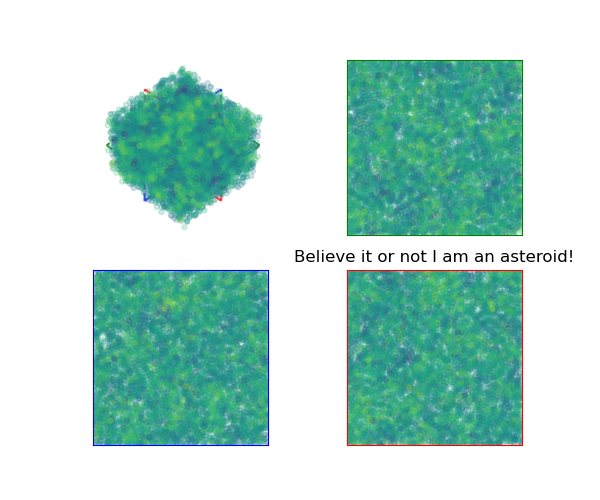

Text(0.5, 1.0, 'Believe it or not I am an asteroid!')

In [6]:
# The rejection plot will visualize the neural density field as a probability distribution function. 
# Colors represent the density magnitude (white being zero). 
# At the beginning, the whole hypercube is filled with some non vanishing density.
gravann.plot_model_rejection(model, encoding, views_2d=True, N=10000, progressbar=True, c=c)
plt.title("Believe it or not I am an asteroid!")

# Training of a geodesyNet

In [7]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Number of points to be used to evaluate numerically the triple integral
# defining the acceleration. 
# Use <=30000 to for a quick training ... 300000 was used to produce most of the paper results
n_quadrature = 300000

# Dimension of the batch size, i.e. number of points
# where the ground truth is compared to the predicted acceleration
# at each training epoch.
# Use 100 for a quick training. 1000  was used to produce most of the paper results
batch_size = 1000

# Loss. The normalized L1 loss (kMAE in the paper) was
# found to be one of the best performing choices.
# More are implemented in the module
loss_fn = gravann.normalized_sqrt_L1_loss

# The numerical Integration method. 
# Trapezoidal integration is here set over a dataset containing acceleration values,
# (it is possible to also train on values of the gravity potential, results are similar)
mc_method = gravann.ACC_trap

# The sampling method to decide what points to consider in each batch.
# In this case we sample points unifromly in a sphere and reject those that are inside the asteroid
targets_point_sampler = gravann.get_target_point_sampler(batch_size, 
                                                         limit_shape_to_asteroid="3dmeshes/Bennu_lp.pk", 
                                                         method="spherical", 
                                                         bounds=[0,1])
# Here we set the optimizer
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.8, patience = 200, min_lr = 1e-9,verbose=True)

# And init the best results
best_loss = np.inf
best_model_state_dict = model.state_dict()

**Note: the cell below is explicitly typed for convenience, as this is a tutorial-ish after all, but the module gravann contains a function (train_on_batch) that does the same**

In [13]:
# TRAINING LOOP (normal training, no use of any prior shape information)------------------------
# This cell can be stopped and started again without loosing memory of the training nor its logs
torch.cuda.empty_cache()
# The main training loop
for i in range(10000):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        target_points = targets_point_sampler()
        # We compute the labels whenever the target points are changed
        labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
    
    # We compute the values predicted by the neural density field
    predicted = mc_method(target_points, model, encoding, N=n_quadrature, noise=0.)
    
    # We learn the scaling constant (k in the paper)
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    
    # We compute the loss (note that the contrastive loss needs a different shape for the labels)
    if loss_fn == gravann.contrastive_loss:
       loss = loss_fn(predicted, labels)
    else:
       loss = loss_fn(predicted.view(-1), labels.view(-1))
    
    # We store the model if it has the lowest fitness 
    # (this is to avoid losing good results during a run that goes wild)
    if loss < best_loss:
        best_model_state_dict = model.state_dict()
        best_loss = loss
        print('New Best: ', loss.item())
        # Uncomment to save the model
        torch.save(model.state_dict(), "models/eros5.mdl")
    
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((n_quadrature*batch_size) // 10000)
    
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
        
    # Zeroes the gradient (necessary because of things)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

New Best:  0.1839214265346527
It=0	 loss=1.839e-01	  weighted_average=1.839e-01	  c=1.085e+01
New Best:  0.16691720485687256
New Best:  0.15684351325035095
New Best:  0.1516680121421814
New Best:  0.14984309673309326
New Best:  0.14808161556720734
New Best:  0.1459614485502243
New Best:  0.14350546896457672
New Best:  0.14127658307552338
New Best:  0.14002607762813568
New Best:  0.13943666219711304
New Best:  0.1378437727689743
New Best:  0.1360289752483368
New Best:  0.13396835327148438
New Best:  0.13169054687023163
New Best:  0.1291736662387848
New Best:  0.12650185823440552
New Best:  0.12363778799772263
New Best:  0.1206737831234932
New Best:  0.11744144558906555
New Best:  0.11538593471050262
New Best:  0.10724951326847076
New Best:  0.10436535626649857
It=25	 loss=1.044e-01	  weighted_average=1.285e-01	  c=9.715e+00
New Best:  0.10279089212417603
New Best:  0.09889716655015945
New Best:  0.09369203448295593
New Best:  0.0907251164317131
New Best:  0.09040378779172897
New Best:  

New Best:  0.0020904969424009323
It=675	 loss=2.090e-03	  weighted_average=2.341e-03	  c=4.905e+00
New Best:  0.002057123463600874
New Best:  0.0019566453993320465
It=700	 loss=2.447e-03	  weighted_average=2.232e-03	  c=4.794e+00
New Best:  0.0019384084735065699
It=725	 loss=1.938e-03	  weighted_average=2.284e-03	  c=4.788e+00
It=750	 loss=2.242e-03	  weighted_average=2.248e-03	  c=4.693e+00
It=775	 loss=2.219e-03	  weighted_average=2.204e-03	  c=4.686e+00
New Best:  0.0019232177874073386
It=800	 loss=2.274e-03	  weighted_average=2.115e-03	  c=4.614e+00
New Best:  0.0018470196519047022
New Best:  0.00177086447365582
It=825	 loss=2.136e-03	  weighted_average=2.131e-03	  c=4.536e+00
New Best:  0.0016852831467986107
It=850	 loss=2.356e-03	  weighted_average=2.011e-03	  c=4.517e+00
It=875	 loss=1.918e-03	  weighted_average=2.085e-03	  c=4.489e+00
It=900	 loss=2.169e-03	  weighted_average=2.008e-03	  c=4.448e+00
It=925	 loss=2.084e-03	  weighted_average=2.097e-03	  c=4.414e+00
It=950	 loss=

It=3025	 loss=9.078e-04	  weighted_average=9.223e-04	  c=3.367e+00
It=3050	 loss=9.030e-04	  weighted_average=9.893e-04	  c=3.373e+00
Epoch  3069: reducing learning rate of group 0 to 2.6214e-06.
It=3075	 loss=9.002e-04	  weighted_average=9.213e-04	  c=3.372e+00
It=3100	 loss=1.053e-03	  weighted_average=9.776e-04	  c=3.364e+00
It=3125	 loss=1.003e-03	  weighted_average=1.004e-03	  c=3.375e+00
New Best:  0.0008084845612756908
New Best:  0.0008045480935834348
New Best:  0.0007907819817773998
New Best:  0.0007886537350714207
New Best:  0.0007823308114893734
New Best:  0.000776557601056993
New Best:  0.0007692792569287121
New Best:  0.0007628100574947894
New Best:  0.0007591369794681668
It=3150	 loss=8.714e-04	  weighted_average=8.840e-04	  c=3.369e+00
It=3175	 loss=8.328e-04	  weighted_average=8.634e-04	  c=3.363e+00
It=3200	 loss=8.288e-04	  weighted_average=8.743e-04	  c=3.375e+00
It=3225	 loss=9.496e-04	  weighted_average=8.397e-04	  c=3.364e+00
It=3250	 loss=1.011e-03	  weighted_aver

It=5500	 loss=8.600e-04	  weighted_average=8.128e-04	  c=3.310e+00
It=5525	 loss=8.315e-04	  weighted_average=8.208e-04	  c=3.307e+00
It=5550	 loss=9.028e-04	  weighted_average=8.767e-04	  c=3.308e+00
It=5575	 loss=7.920e-04	  weighted_average=8.196e-04	  c=3.306e+00
It=5600	 loss=8.049e-04	  weighted_average=7.929e-04	  c=3.307e+00
Epoch  5606: reducing learning rate of group 0 to 2.2518e-07.
It=5625	 loss=7.890e-04	  weighted_average=8.260e-04	  c=3.312e+00
It=5650	 loss=8.481e-04	  weighted_average=8.193e-04	  c=3.307e+00
It=5675	 loss=7.876e-04	  weighted_average=8.435e-04	  c=3.305e+00
It=5700	 loss=7.543e-04	  weighted_average=7.516e-04	  c=3.303e+00
It=5725	 loss=8.180e-04	  weighted_average=8.165e-04	  c=3.312e+00
It=5750	 loss=8.342e-04	  weighted_average=8.412e-04	  c=3.305e+00
It=5775	 loss=8.687e-04	  weighted_average=8.144e-04	  c=3.307e+00
It=5800	 loss=8.378e-04	  weighted_average=7.906e-04	  c=3.310e+00
Epoch  5807: reducing learning rate of group 0 to 1.8014e-07.
It=58

It=7875	 loss=7.291e-04	  weighted_average=7.949e-04	  c=3.297e+00
It=7900	 loss=8.260e-04	  weighted_average=8.067e-04	  c=3.297e+00
It=7925	 loss=8.014e-04	  weighted_average=8.093e-04	  c=3.299e+00
It=7950	 loss=7.427e-04	  weighted_average=7.411e-04	  c=3.299e+00
It=7975	 loss=8.683e-04	  weighted_average=8.749e-04	  c=3.295e+00
It=8000	 loss=8.226e-04	  weighted_average=7.891e-04	  c=3.297e+00
It=8025	 loss=8.404e-04	  weighted_average=7.771e-04	  c=3.298e+00
It=8050	 loss=7.403e-04	  weighted_average=8.515e-04	  c=3.300e+00
It=8075	 loss=8.264e-04	  weighted_average=9.450e-04	  c=3.306e+00
It=8100	 loss=8.811e-04	  weighted_average=7.784e-04	  c=3.297e+00
It=8125	 loss=8.472e-04	  weighted_average=8.739e-04	  c=3.298e+00
It=8150	 loss=7.722e-04	  weighted_average=7.756e-04	  c=3.297e+00
It=8175	 loss=7.220e-04	  weighted_average=7.743e-04	  c=3.298e+00
It=8200	 loss=7.892e-04	  weighted_average=7.898e-04	  c=3.300e+00
It=8225	 loss=7.335e-04	  weighted_average=7.639e-04	  c=3.298

KeyboardInterrupt: 

In [14]:
# Here we restore the learned parameters of the best model of the run
for layer in model.state_dict():
    model.state_dict()[layer] = best_model_state_dict[layer]

# Interpretation of the neural density field learned

<IPython.core.display.Javascript object>


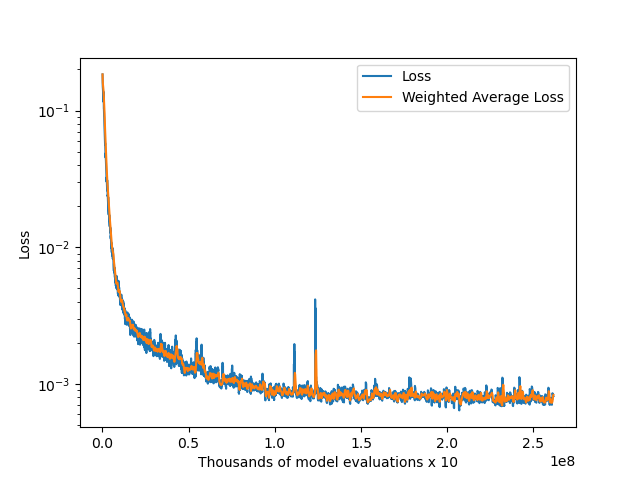

In [15]:
# First lets have a look at the training loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa,  loss_log)
plt.semilogy(abscissa,  weighted_average_log)
plt.xlabel("Thousands of model evaluations x 10")
plt.ylabel("Loss")
plt.legend(["Loss","Weighted Average Loss"])

Sampling points...: 1744it [00:01, 1319.75it/s]                                                                        


<IPython.core.display.Javascript object>


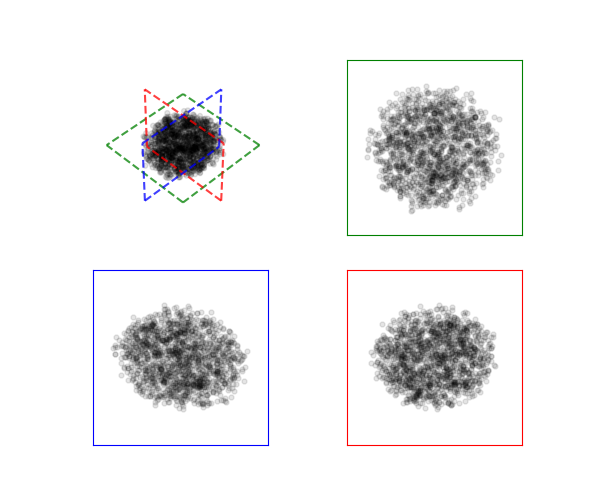

<IPython.core.display.Javascript object>


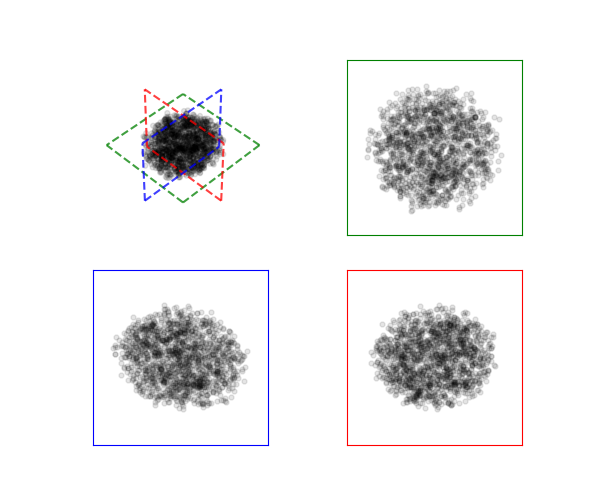

In [16]:
# Lets have a look at the neural density field.
# First with a rejection plot
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=1500, alpha=0.1, s=50, c=c, crop_p=0.1, progressbar=True)

Sampling points...: 5167it [00:03, 1476.02it/s]                                                                        


<IPython.core.display.Javascript object>


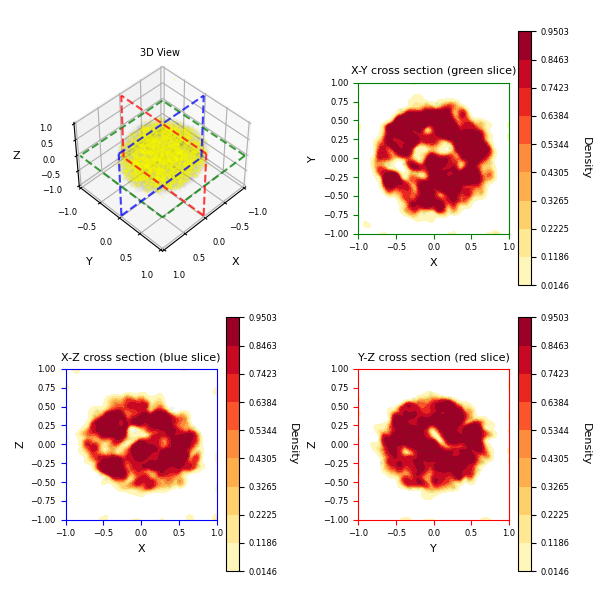

<Axes3DSubplot:title={'center':'3D View'}, xlabel='X', ylabel='Y'>

In [17]:
# Then overlaying a heatmap to the mascons 
gravann.plot_model_vs_mascon_contours(model, encoding, mascon_points, mascon_masses,c=c, progressbar = True, N=5000, heatmap=True)

In [18]:
# Computes the Validation table with rel and abs errors on the predicted acceleration (w.r.t. ground truth) 
# at low, med, high altitudes (see paper). is requires sampling quite a lot, so it takes time 
gravann.validation(model, encoding, mascon_points, mascon_masses, use_acc=True, asteroid_pk_path="3dmeshes/Hollow2.pk", N=10000, N_integration=300000, batch_size=32, progressbar=True)

Computing validation...:  57%|████████████████████████████▎                     | 39200/69204 [01:27<01:07, 444.40it/s]

Discarding 1829 of 12288 points in altitude sampler which did not meet requested altitude.


Computing validation...:  71%|███████████████████████████████████▌              | 49216/69204 [02:29<01:42, 194.69it/s]

Discarding 5600 of 12288 points in altitude sampler which did not meet requested altitude.


Computing validation...:  86%|██████████████████████████████████████████▊       | 59200/69204 [03:27<00:51, 193.53it/s]

Discarding 9745 of 12288 points in altitude sampler which did not meet requested altitude.


Computing validation...: 100%|█████████████████████████████████████████████████▉| 69184/69204 [04:23<00:00, 262.16it/s]


,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.087327,0.177701,0.744884,0.468568
1,High Altitude,0.000326,0.000871,0.003720,0.003538
2,Altitude_0,0.001049,0.002147,0.003772,0.002580
3,Altitude_1,0.000272,0.000629,0.002084,0.001619
4,Altitude_2,0.000501,0.001611,0.002156,0.002332


In [7]:
# Computes the Validation table with rel and abs errors on the predicted acceleration (w.r.t. ground truth) 
# at low, med, high altitudes (see paper). is requires sampling quite a lot, so it takes time 
gravann.validation(model, encoding, mascon_points, mascon_masses, use_acc=True, asteroid_pk_path="3dmeshes/Eros.pk", N=10000, N_integration=300000, batch_size=32, progressbar=True)

Computing validation...:  60%|█████████████████████████████▊                    | 44288/74244 [01:38<01:07, 442.85it/s]

Discarding 4193 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  73%|████████████████████████████████████▌             | 54272/74244 [02:42<01:45, 189.98it/s]

Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  87%|███████████████████████████████████████████▎      | 64256/74244 [03:44<00:53, 186.44it/s]

Discarding 11243 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 100%|█████████████████████████████████████████████████▉| 74240/74244 [04:43<00:00, 261.71it/s]


,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.028174,0.018238,0.272122,0.055747
1,High Altitude,0.002311,0.001711,0.012548,0.002981
2,Altitude_0,0.002090,0.001599,0.007827,0.001992
3,Altitude_1,0.000416,0.000386,0.001434,0.000446
4,Altitude_2,0.000052,0.000081,0.000192,0.000100


In [19]:
# Shows how the relative error is distribued along the asteroid surface (at some altitude) 
gravann.plot_model_mascon_acceleration("3dmeshes/Eros.pk", model, encoding, mascon_points, mascon_masses, plane="XY", c=c, N=5000, logscale=False, altitude=0.1)

Sampling points at altitude
Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.
Got  5000  points.
Splitting in left / right hemisphere
Left:  2413  points.
Right:  2587  points.


NameError: name 'sobol_points' is not defined

<IPython.core.display.Javascript object>


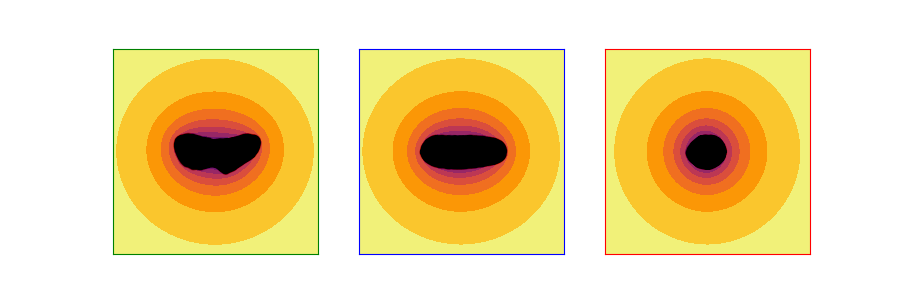

<AxesSubplot:>

In [15]:
# Shows the Contour plot of the gravity potential generated by the neural density field.
gravann.plot_potential_contours(model, encoding, mascon_points)

#### Saving the model

In [21]:
# Uncomment to save the model
torch.save(model.state_dict(), "models/planetesimal.mdl")

In [19]:
y = torch.ones(1000,1)*0.
z = torch.ones(1000,1)*0.
x = torch.linspace(-1,1,1000).view(-1,1)
points = torch.concat((x,y,z), dim=1)

<IPython.core.display.Javascript object>


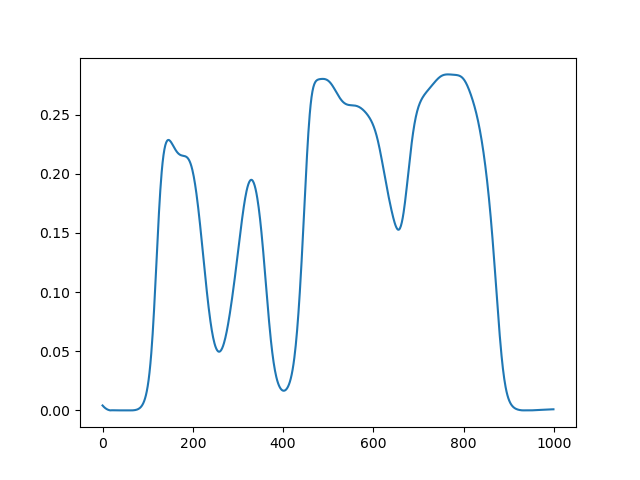

In [20]:
plt.figure()
plt.plot(model(points).detach().cpu().numpy())

In [35]:
model(points)

tensor([[9.6485e-07],
        [1.1288e-06],
        [1.3076e-06],
        [1.5125e-06],
        [1.7323e-06],
        [1.9744e-06],
        [2.2277e-06],
        [2.4922e-06],
        [2.7567e-06],
        [3.0249e-06],
        [3.2932e-06],
        [3.5465e-06],
        [3.7812e-06],
        [3.9898e-06],
        [4.1761e-06],
        [4.3362e-06],
        [4.4592e-06],
        [4.5523e-06],
        [4.6119e-06],
        [4.6454e-06],
        [4.6305e-06],
        [4.5933e-06],
        [4.5300e-06],
        [4.4443e-06],
        [4.3288e-06],
        [4.2021e-06],
        [4.0419e-06],
        [3.8780e-06],
        [3.6769e-06],
        [3.4645e-06],
        [3.2261e-06],
        [2.9542e-06],
        [2.6487e-06],
        [2.2985e-06],
        [1.9036e-06],
        [1.4491e-06],
        [9.2015e-07],
        [3.2410e-07],
        [3.6880e-07],
        [1.1511e-06],
        [2.0415e-06],
        [3.0436e-06],
        [4.1611e-06],
        [5.3793e-06],
        [6.7167e-06],
        [8